In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Geometric Brownian Motion

In [6]:
def GBM(s0, mu, sigma, T, n, m):
    """
    T: 總時間
    n: 時間步數
    m: 模擬次數
    """
    dt = T / n
    t = np.linspace(0, T, n + 1)
    S = np.zeros((m, n + 1))
    S[:, 0] = s0

    for i in range(m):
        for j in range(n):
            dW = np.random.randn() * np.sqrt(dt)
            S[i, j+1] = S[i, j] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * dW)

    return t, S

In [7]:
def  plot_GBM(s0, mu, sigma, T, n, m):
    
    t, s = GBM(s0, mu, sigma, T, n, m)

    plt.plot(t, s.T)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Geometric Brownian Motion')
    plt.show()

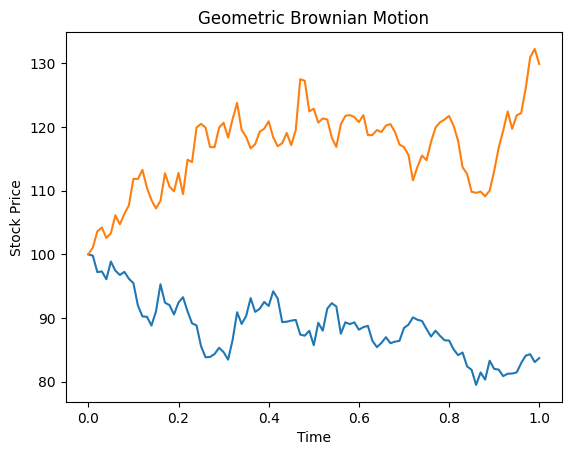

In [12]:
plot_GBM(100, 0.05, 0.2, 1, 100, 2)

### MonteCarlo Simulation of European Option

In [ ]:
def amc_option(s, k, r, t, v, n, m, option_type = 'call'):

    dt = t / n
    drift = (r - 0.5 * v ** 2) * dt
    sum_payoff = 0

    for _ in range(m):
        st = s
        for _ in range(n):
            st *= np.exp(drift + v * np.sqrt(dt) * np.random.randn())
        if option_type == 'call':
            sum_payoff += max(st - k, 0)
        elif option_type == 'put':
            sum_payoff += max(k - st, 0)
        else:
            raise ValueError("Invalid option_type. Use 'call' or 'put'.")

    option_price = np.exp(-r * t) * (sum_payoff / m)
    
    return option_price

In [44]:
s, k, r, t, v, n, m = 100, 100, 0.1, 1, 0.2, 1, 10000

call_option_price = amc_option(s, k, r, t, v, n, m, option_type = 'call')
put_option_price = amc_option(s, k, r, t, v, n, m, option_type = 'put')

print(f"Call Option Price: {call_option_price}")
print(f"Put Option Price: {put_option_price}")

Call Option Price: 13.318710871145054
Put Option Price: 3.709891159918187


### Anti-Variate Simulation

In [ ]:
def amc_option_antithetic(s, k, r, t, v, n, m, option_type = 'call'):
    
    dt = t / n
    drift = (r - 0.5 * v ** 2) * dt
    discount_factor = np.exp(-r * t)
    sum_payoff = 0

    for _ in range(m // 2):
        z = np.random.randn()
        z_antithetic = -z

        st = s
        for _ in range(n):
            st *= np.exp(drift + v * np.sqrt(dt) * z)

        st_antithetic = s
        for _ in range(n):
            st_antithetic *= np.exp(drift + v * np.sqrt(dt) * z_antithetic)

        if option_type == 'call':
            payoff_1 = max(st - k, 0)
            payoff_2 = max(st_antithetic - k, 0)
        elif option_type == 'put':
            payoff_1 = max(k - st, 0)
            payoff_2 = max(k - st_antithetic, 0)
        else:
            raise ValueError("Invalid option_type. Use 'call' or 'put'.")

        sum_payoff += (payoff_1 + payoff_2) / 2

    option_price = discount_factor * (sum_payoff / (m // 2))

    return option_price

In [50]:
s, k, r, t, v, n, m = 100, 100, 0.1, 1, 0.2, 1, 10000

call_option_price = amc_option_antithetic(s, k, r, t, v, n, m, option_type = 'call')

print(f"Call Option Price: {call_option_price}")

Call Option Price: 13.352110931629529


### Control Variate Method

In [53]:
def control_variate_option(s, k, r, t, v, n, m, option_type = 'call'):
    dt = t / n
    drift = (r - 0.5 * v ** 2) * dt
    discount_factor = np.exp(-r * t)

    sum_payoff = 0
    sum_control_variate = 0

    for _ in range(m):
        z = np.random.randn()

        st = s
        for _ in range(n):
            st *= np.exp(drift + v * np.sqrt(dt) * z)

        vs = s * np.exp(r * t)  # 類似選擇權的模擬價格（用無風險資產）

        if option_type == 'call':
            payoff = max(st - k, 0)
            control_variate = max(vs - k, 0)
        elif option_type == 'put':
            payoff = max(k - st, 0)
            control_variate = max(k - vs, 0)
        else:
            raise ValueError("Invalid option_type. Use 'call' or 'put'.")

        sum_payoff += payoff
        sum_control_variate += control_variate

    cs = discount_factor * (sum_payoff / m)
    vs = discount_factor * (sum_control_variate / m)
    vt = max(s * np.exp(r * t) - k, 0) if option_type == 'call' else max(k - s * np.exp(r * t), 0)

    ct = cs + (vt - vs)

    return cs, ct

In [54]:
s, k, r, t, v, n, m = 100, 100, 0.05, 1, 0.2, 100, 10000
cs_call, ct_call = control_variate_option(s, k, r, t, v, n, m, option_type='call')

print(f"原始蒙地卡羅買權（Call Option）：{cs_call:.4f}")
print(f"控制變異法買權（Call Option）：{ct_call:.4f}")

原始蒙地卡羅買權（Call Option）：614.9529
控制變異法買權（Call Option）：615.2030


### Average Option

In [51]:
def amc_average_option(s0, k, r, t, v, n, m):
    dt = t / n
    drift = (r - 0.5 * v ** 2) * dt
    discount = np.exp(-r * t)
    
    sum_fc = 0

    for _ in range(m):
        st = np.zeros(n + 1)
        st[0] = s0
        sums = s0

        for j in range(1, n + 1):
            st[j] = st[j-1] * np.exp(drift + v * np.sqrt(dt) * np.random.randn())
            sums += st[j]

        s_mean = sums / (n + 1)
        fc = discount * max(s_mean - k, 0)
        sum_fc += fc

    averat = sum_fc / m
    return averat

In [52]:
s0, k, r, t, v, n, m = 100, 100, 0.1, 1, 0.2, 100, 1000

average_call_price = amc_average_option(s0, k, r, t, v, n, m)
print(f"平均選擇權（Asian Call Option）價格: {average_call_price:.4f}")

平均選擇權（Asian Call Option）價格: 7.0206
